# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import itertools
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\javir\EVERYTHING\WORK\ICAI\Master\Cuatri_1\Ética\Labs\p1-tabular-methods-JavierRojo8\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

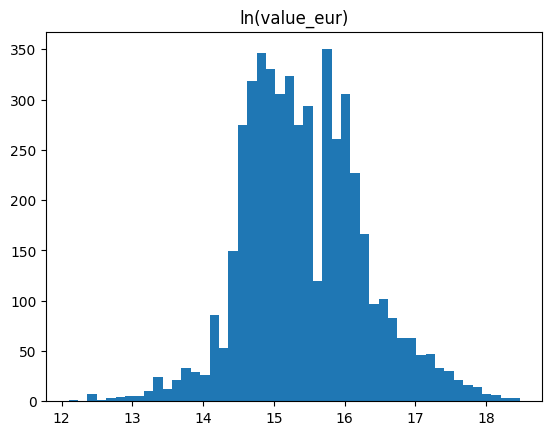

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [6]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [8]:
# To show overfitting, compute R2 on train and test
r2_train = model.score(X_train, ylog_train)
r2_test = model.score(X_test, ylog_test)
print(f"R2 train: {r2_train:.3f}, R2 test: {r2_test:.3f}")

R2 train: 0.997, R2 test: 0.926


There is some overfitting, since we get a much higher R2 on train than on test.

However, the test results are still very good for this type of data.

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [21]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

In [10]:
# We will use the shap barplot summed by variable groups to show the importance of each group
X100 = shap.utils.sample(X, 100, random_state=42)

explainer = shap.TreeExplainer(model, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test)

Shap Graphs for individual categories

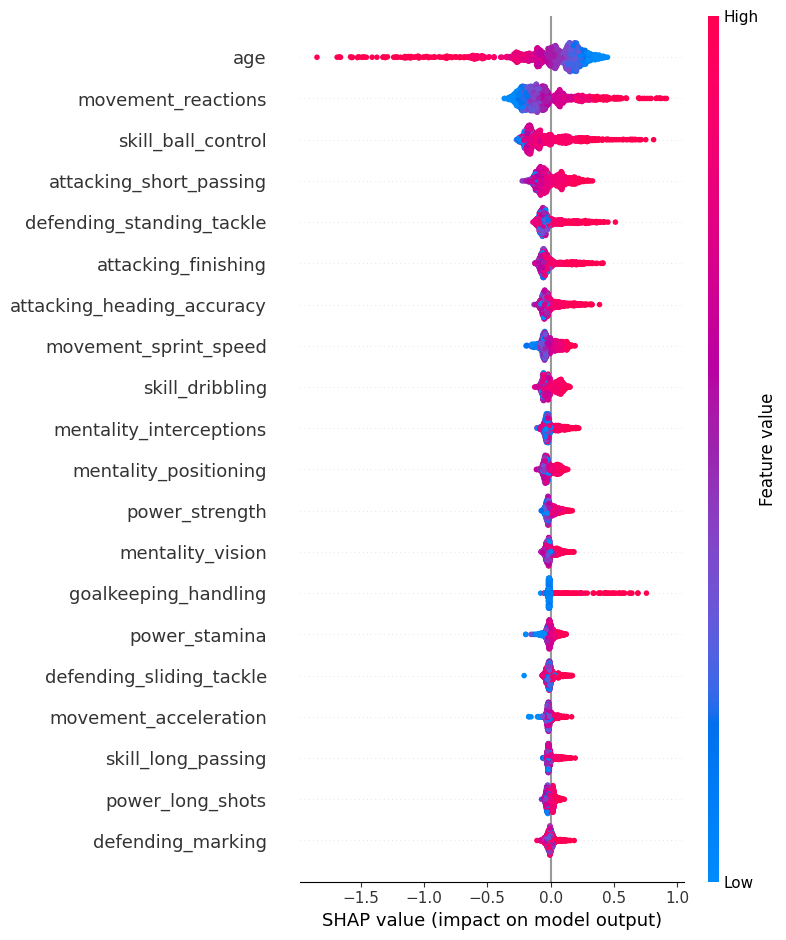

In [11]:
shap.summary_plot(shap_values, X_test)

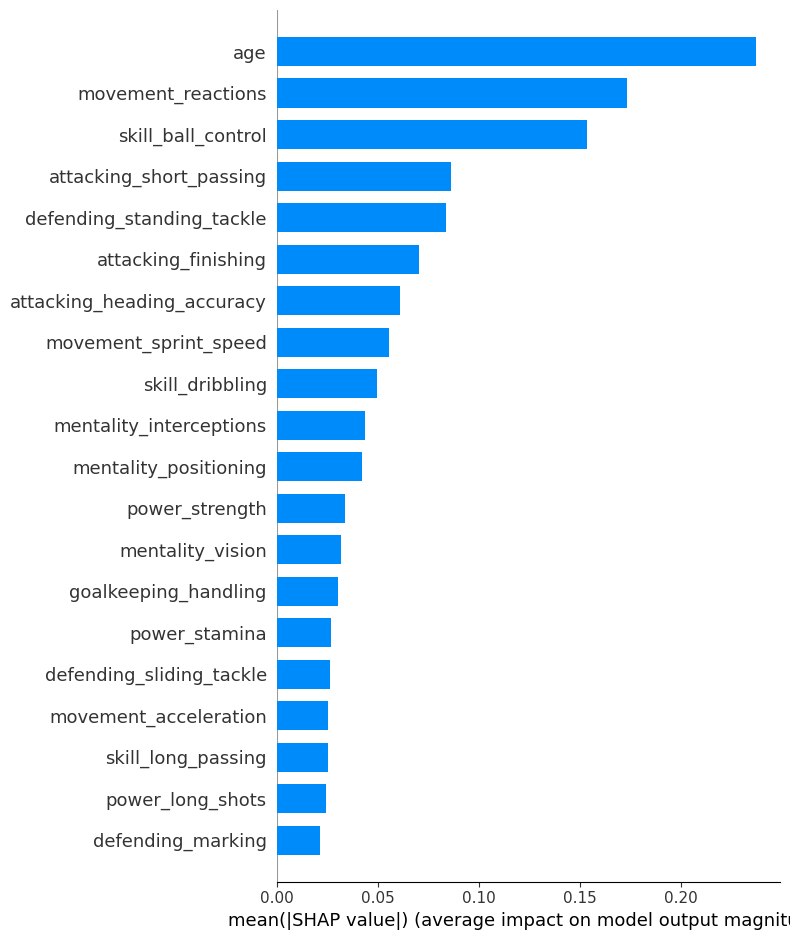

In [12]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Variable importance per group

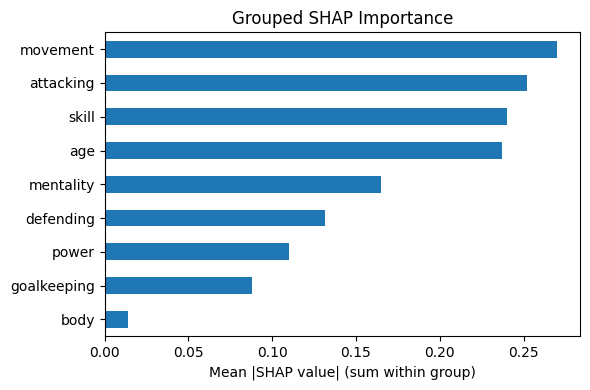

In [13]:
# Mean absolute SHAP values per feature
mean_abs_shap = pd.Series(abs(shap_values).mean(axis=0), index=X_test.columns)
# Add values by group
group_importance = {group: mean_abs_shap[features].sum() for group, features in variable_groups.items()}
group_importance = pd.Series(group_importance).sort_values(ascending=True)

# PLot
plt.figure(figsize=(6, 4))
group_importance.plot(kind='barh')
plt.title("Grouped SHAP Importance")
plt.xlabel("Mean |SHAP value| (sum within group)")
plt.tight_layout()
plt.show()


It seems that movement, atacking, skill and age are the more important qualities in determining the value of a player, while the body is the least important part. It makes sense in imagining an agile and electric player that can impact the game in a fast paced manner. 

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

In [14]:
messi = df[df['short_name'] == 'L. Messi'].drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
messi_y = df[df['short_name']== 'L. Messi']['value_eur']
messi

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,32,170,72,88,95,70,92,88,97,93,...,75,96,33,37,26,6,11,15,14,8


In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

messi_index = df[df['short_name'] == 'L. Messi'].index[0]
messi_instance = X.iloc[messi_index]

# Get Messi’s SHAP contributions
messi_shap = pd.Series(shap_values[messi_index], index=X.columns)

# Identify the most influential variable (absolute contribution)
top_feature = messi_shap.abs().idxmax()
top_contribution = messi_shap[top_feature]

print(top_feature)

movement_reactions


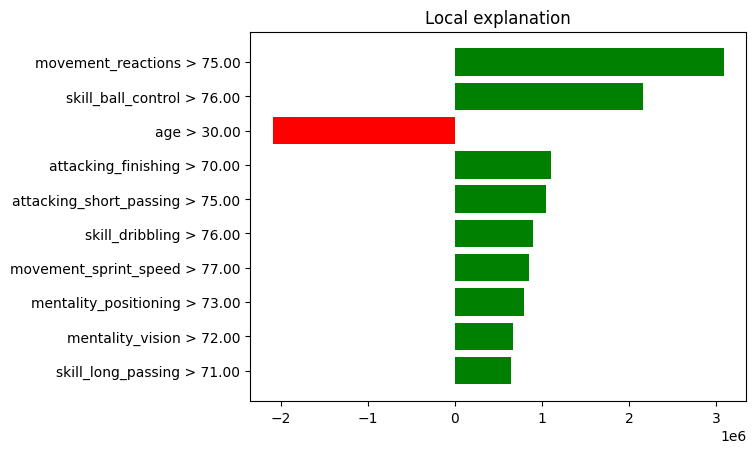

In [41]:
kernel_width = 3
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression',
    kernel_width=kernel_width
)
exp = explainer.explain_instance(
    data_row=messi.iloc[0],
    predict_fn=lambda x: predict_function(model, pd.DataFrame(x, columns=X_train.columns))
)
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show()

>>> Your justification here

SHAP explains individual predictions by quantifying how each feature contributes to a specific outcome. In this case, it effectively reveals which variables most influence Leo Messi’s market value. The analysis shows that movement_reactions is the most significant factor, players with lower scores in this attribute tend to have much lower market values. Also, using LIME we can see that age has a strong negative influence because players of Messi’s age are generally valued far less, making him a clear outlier whose exceptional ability defies typical age trends.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

In [16]:
siuuu = df[df['short_name'] == 'Cristiano Ronaldo'].drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1) 
siuuu_y = df[df['short_name']== 'Cristiano Ronaldo']['value_eur']
siuuu

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
1,34,187,83,84,94,89,83,87,89,81,...,85,95,28,32,24,7,11,15,14,11


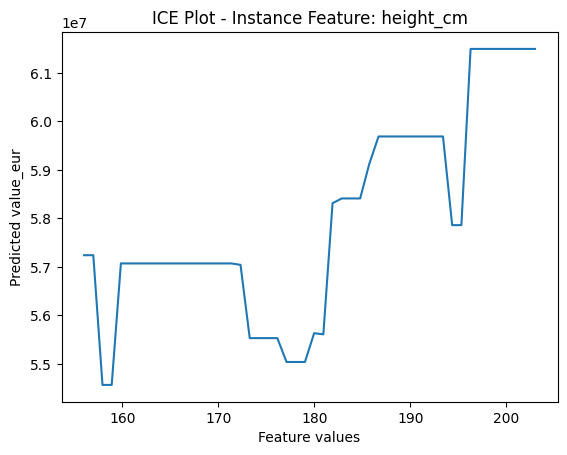

In [17]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = df[df['short_name'] == 'Cristiano Ronaldo'].index[0]
feature_index = X.columns.get_loc("height_cm")

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = predict_function(model, instance_modified)

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted value_eur')
plt.title(f'ICE Plot - Instance Feature: {X.columns[feature_index]}')
plt.show()

>>> Your explanation here

We are just taking the line for the Cristiano Ronaldo instance and changing the height_cm feature to see how the model outputs something different.
As we can see the relationship is ascending, as one would expect a taller player with longer legs to run faster and be able to hit more headers maybe, although as we can observe the relationship is far from linear. It takes into acount strong dips in apparently arbitrary heights.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

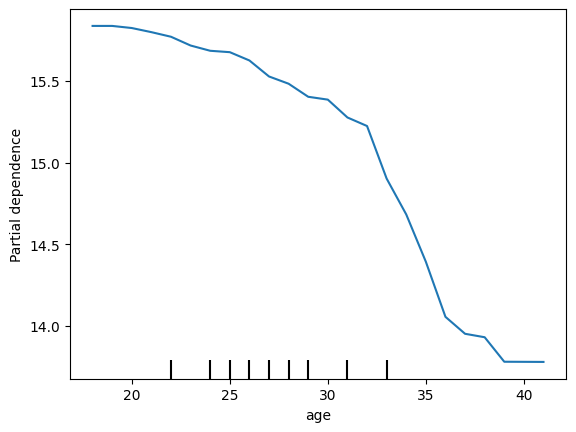

In [20]:
# Choose the feature of interest
features = ["age"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both' if you also want the ICE plots

>>> Your explanation here

The expected value of the player decreases as he gets older, which is something understandable since they are closer to retirement, so they won't be able to improve too much and their physicality decreases. For this we used a PDP plot to see how for each instance changing the age value the prediction changed. We then average the values for each different age value and see this graph. 

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [27]:
hazard = df[df['short_name'] == 'E. Hazard'].drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
hazard

,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
4,28,175,74,81,84,61,89,83,95,83,...,88,91,34,27,22,11,12,6,8,8


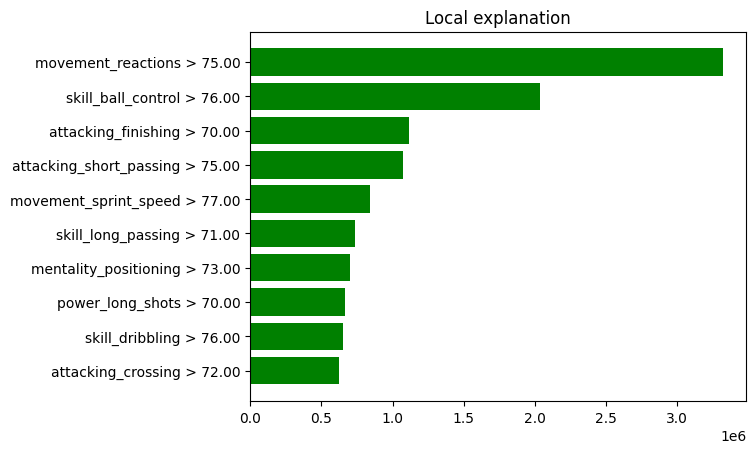

In [29]:
kernel_width = 3
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression',
    kernel_width=kernel_width
)
exp = explainer.explain_instance(
    data_row=hazard.iloc[0],
    predict_fn=lambda x: predict_function(model, pd.DataFrame(x, columns=X_train.columns))
)
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show()

>>> Your explanation here

All his attributes point him in the right direction, showing he's above the threshold for everything, improving his value as a player. The most "expensive" quality, seems to be movement reaction, since it is much more than the threshold and must be quite scarce to have that value on that feature